# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
data_dir="E:\DL_training_datas\celeba"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

  Using cached https://files.pythonhosted.org/packages/f5/f0/9da3ef24ea7eb0ccd12430a261b66eca36b924aeef06e17147f9f9d7d310/matplotlib-2.0.2.tar.gz
    Complete output from command python setup.py egg_info:
    Edit setup.cfg to change the build options
    
    BUILDING MATPLOTLIB
                matplotlib: yes [2.0.2]
                    python: yes [3.7.3 (default, Mar 27 2019, 17:13:21) [MSC
                            v.1915 64 bit (AMD64)]]
                  platform: yes [win32]
    
    REQUIRED DEPENDENCIES AND EXTENSIONS
                     numpy: yes [version 1.16.2]
                       six: yes [using six version 1.12.0]
                  dateutil: yes [using dateutil version 2.8.0]
               functools32: yes [Not required]
              subprocess32: yes [Not required]
                      pytz: yes [using pytz version 2018.9]
                    cycler: yes [using cycler version 0.10.0]
                   tornado: yes [using tornado version 6.0.2]
               

Command "python setup.py egg_info" failed with error code 1 in C:\Users\纯\AppData\Local\Temp\pip-install-gt6smfne\matplotlib\


Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

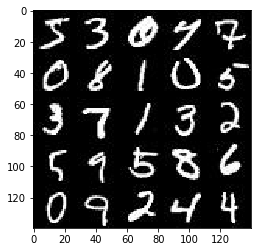

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

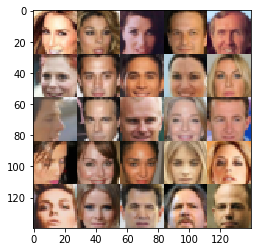

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

W0927 20:52:20.968311 19384 deprecation_wrapper.py:119] From E:\SDC_Pros\DeepLearning\04_face-generation\problem_unittests.py:20: The name tf.assert_rank is deprecated. Please use tf.compat.v1.assert_rank instead.



Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    dropout = 0.5#dropout 在20% 到 50%之间。
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha *x1, x1)#Leaky ReLU
        #在Leaky ReLU 之后加 dropout层， 可以防止discriminator只看图片中的特定几块区域而忽略整体来判断是否为真图。 
        #请注意！运用#dropout 在20% 到 50%之间。
        x1 = tf.nn.dropout(x1, dropout)#Optimized
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha *x2, x2)
        x2 = tf.nn.dropout(x2, dropout)#Optimized
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha *x3, x3)
        x3 = tf.nn.dropout(x3, dropout)#Optimized
        
        flat = tf.reshape(x3, (-1,7*7*256))
        logits = tf.layers.dense(flat, 1)
     
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha *x1, x1)#leaky relu
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha *x2, x2)
     
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha *x3, x3)
      
#         x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
#         x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = tf.maximum(alpha *x4, x4)
    
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

W0927 20:59:23.645612 19384 deprecation.py:323] From <ipython-input-8-c837457e411d>:17: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    #Optimized:To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example, using the parameter smooth. This is known as label smoothing, typically used with classifiers to improve performance. 
    #In TensorFlow, it looks something like labels = tf.ones_like(tensor) * (1 - smooth)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

W0927 20:59:55.970831 19384 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

W0927 21:00:05.252323 19384 deprecation_wrapper.py:119] From E:\SDC_Pros\DeepLearning\04_face-generation\problem_unittests.py:46: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1,smooth, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    steps = 0    
#     out_channel_dim = 3 if(data_image_mode == "RGB") else 1
    
#     input_real, batch_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], smooth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z,lr:learning_rate})
               
                # Optimzed:Run g_optim twice to make sure that d_loss does not go to zero
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images,lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    gen_samples = sess.run(generator(input_z,data_shape[3], is_train=False),
                                          feed_dict={input_z:batch_z})
                    samples.append(gen_samples)
#                     _ = view_s
                    show_generator_output(sess,25,input_z, data_shape[3], data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')   
        
        return losses, samples  
        
                              
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 2.3169... Generator Loss: 0.5773...
Epoch 1/2... Discriminator Loss: 2.0028... Generator Loss: 0.7502...
Epoch 1/2... Discriminator Loss: 2.0887... Generator Loss: 0.5756...
Epoch 1/2... Discriminator Loss: 1.7082... Generator Loss: 0.7941...
Epoch 1/2... Discriminator Loss: 1.7330... Generator Loss: 1.1041...
Epoch 1/2... Discriminator Loss: 1.6917... Generator Loss: 1.0345...
Epoch 1/2... Discriminator Loss: 2.3119... Generator Loss: 0.6421...
Epoch 1/2... Discriminator Loss: 2.4239... Generator Loss: 0.8516...
Epoch 1/2... Discriminator Loss: 1.9247... Generator Loss: 0.8947...
Epoch 1/2... Discriminator Loss: 2.1354... Generator Loss: 1.0302...


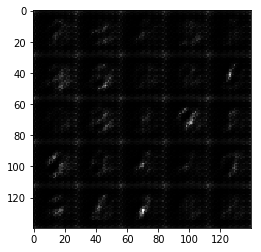

Epoch 1/2... Discriminator Loss: 1.7253... Generator Loss: 1.1421...
Epoch 1/2... Discriminator Loss: 1.9340... Generator Loss: 0.8138...
Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 1.1015...
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.9670...
Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 0.9519...
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.8220...
Epoch 1/2... Discriminator Loss: 1.7592... Generator Loss: 0.8293...
Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 1.0770...
Epoch 1/2... Discriminator Loss: 1.7654... Generator Loss: 0.7062...
Epoch 1/2... Discriminator Loss: 1.7407... Generator Loss: 0.9597...


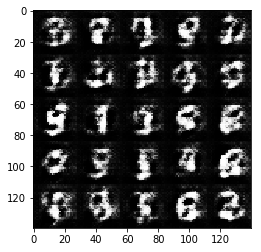

Epoch 1/2... Discriminator Loss: 1.7531... Generator Loss: 0.9136...
Epoch 1/2... Discriminator Loss: 1.8699... Generator Loss: 0.8442...
Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.8682...
Epoch 1/2... Discriminator Loss: 1.6434... Generator Loss: 0.8005...
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.8115...
Epoch 1/2... Discriminator Loss: 1.6494... Generator Loss: 0.9668...
Epoch 1/2... Discriminator Loss: 1.7607... Generator Loss: 0.7300...
Epoch 1/2... Discriminator Loss: 1.5610... Generator Loss: 0.8267...
Epoch 1/2... Discriminator Loss: 1.5847... Generator Loss: 1.2088...
Epoch 1/2... Discriminator Loss: 1.5652... Generator Loss: 0.8902...


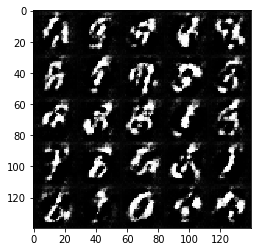

Epoch 1/2... Discriminator Loss: 1.6229... Generator Loss: 1.1046...
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.8475...
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 1.1577...
Epoch 1/2... Discriminator Loss: 1.6062... Generator Loss: 0.7692...
Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 0.8866...
Epoch 1/2... Discriminator Loss: 1.5238... Generator Loss: 0.7529...
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.7921...
Epoch 1/2... Discriminator Loss: 1.5336... Generator Loss: 0.8114...
Epoch 1/2... Discriminator Loss: 1.6820... Generator Loss: 1.0683...
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 0.9971...


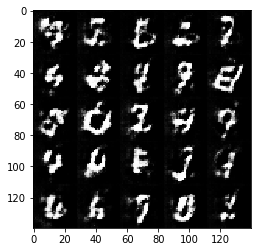

Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 1.0224...
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.8439...
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.8590...
Epoch 1/2... Discriminator Loss: 1.6017... Generator Loss: 0.8793...
Epoch 1/2... Discriminator Loss: 1.5667... Generator Loss: 0.9653...
Epoch 1/2... Discriminator Loss: 1.5852... Generator Loss: 1.2709...
Epoch 2/2... Discriminator Loss: 1.5024... Generator Loss: 0.9040...
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.9980...
Epoch 2/2... Discriminator Loss: 1.5087... Generator Loss: 0.7247...
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 1.0493...


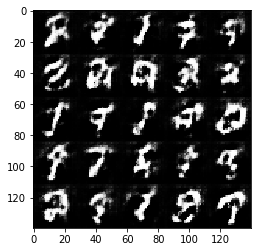

Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 1.0683...
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: 1.0035...
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 1.0420...
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.8053...
Epoch 2/2... Discriminator Loss: 1.6103... Generator Loss: 0.8975...
Epoch 2/2... Discriminator Loss: 1.5738... Generator Loss: 1.1320...
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.9220...
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 1.0425...
Epoch 2/2... Discriminator Loss: 1.5025... Generator Loss: 1.0451...
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 0.8545...


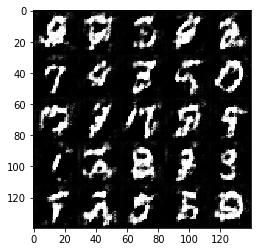

Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 0.8086...
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.7593...
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 1.1332...
Epoch 2/2... Discriminator Loss: 1.5057... Generator Loss: 0.7905...
Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.6648...
Epoch 2/2... Discriminator Loss: 1.5039... Generator Loss: 0.8129...
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.8764...
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.7625...
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.8231...
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.7443...


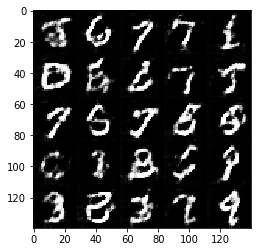

Epoch 2/2... Discriminator Loss: 1.5102... Generator Loss: 1.0016...
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 1.0902...
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.8994...
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.7909...
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.8382...
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.9661...
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.8174...
Epoch 2/2... Discriminator Loss: 1.6129... Generator Loss: 0.8244...
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.6911...
Epoch 2/2... Discriminator Loss: 1.5112... Generator Loss: 0.7891...


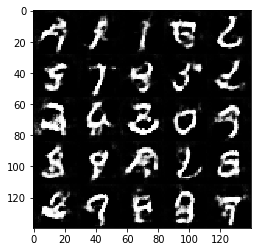

Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.8718...
Epoch 2/2... Discriminator Loss: 1.4987... Generator Loss: 1.1706...
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 1.0068...
Epoch 2/2... Discriminator Loss: 1.4180... Generator Loss: 0.8654...
Epoch 2/2... Discriminator Loss: 1.4972... Generator Loss: 0.6466...
Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.7698...
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.7379...
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.9750...
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.9119...
Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 0.8363...


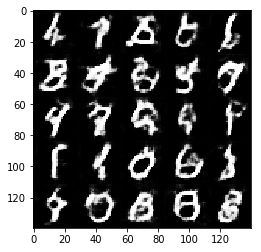

Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.8623...
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.8605...
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.8140...


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4#很重要
smooth = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1,smooth, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/5... Discriminator Loss: 2.1923... Generator Loss: 0.3651...
Epoch 1/5... Discriminator Loss: 2.5405... Generator Loss: 0.6319...
Epoch 1/5... Discriminator Loss: 2.2245... Generator Loss: 1.0192...
Epoch 1/5... Discriminator Loss: 2.7586... Generator Loss: 0.7131...
Epoch 1/5... Discriminator Loss: 2.7561... Generator Loss: 0.6053...
Epoch 1/5... Discriminator Loss: 1.8692... Generator Loss: 0.8158...
Epoch 1/5... Discriminator Loss: 1.8700... Generator Loss: 1.0101...
Epoch 1/5... Discriminator Loss: 1.7380... Generator Loss: 1.2356...
Epoch 1/5... Discriminator Loss: 1.3379... Generator Loss: 1.7653...
Epoch 1/5... Discriminator Loss: 1.5687... Generator Loss: 0.8646...


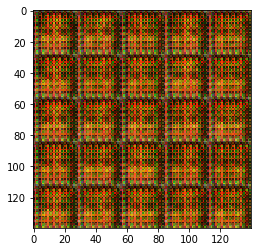

Epoch 1/5... Discriminator Loss: 1.5346... Generator Loss: 1.2668...
Epoch 1/5... Discriminator Loss: 1.5204... Generator Loss: 1.3805...
Epoch 1/5... Discriminator Loss: 1.7875... Generator Loss: 0.7966...
Epoch 1/5... Discriminator Loss: 1.6030... Generator Loss: 1.0237...
Epoch 1/5... Discriminator Loss: 1.6237... Generator Loss: 1.1168...
Epoch 1/5... Discriminator Loss: 1.8724... Generator Loss: 0.9501...
Epoch 1/5... Discriminator Loss: 1.8322... Generator Loss: 0.7648...
Epoch 1/5... Discriminator Loss: 2.1879... Generator Loss: 0.7344...
Epoch 1/5... Discriminator Loss: 1.9453... Generator Loss: 0.8807...
Epoch 1/5... Discriminator Loss: 2.2189... Generator Loss: 0.9151...


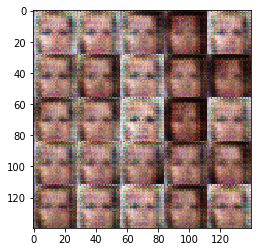

Epoch 1/5... Discriminator Loss: 1.4931... Generator Loss: 0.8423...
Epoch 1/5... Discriminator Loss: 1.5231... Generator Loss: 0.9398...
Epoch 1/5... Discriminator Loss: 1.6250... Generator Loss: 0.9083...
Epoch 1/5... Discriminator Loss: 1.3968... Generator Loss: 0.9003...
Epoch 1/5... Discriminator Loss: 1.4826... Generator Loss: 1.0030...
Epoch 1/5... Discriminator Loss: 1.3889... Generator Loss: 1.0905...
Epoch 1/5... Discriminator Loss: 2.1399... Generator Loss: 0.5107...
Epoch 1/5... Discriminator Loss: 1.7053... Generator Loss: 0.8978...
Epoch 1/5... Discriminator Loss: 1.3680... Generator Loss: 1.0225...
Epoch 1/5... Discriminator Loss: 1.6172... Generator Loss: 0.7439...


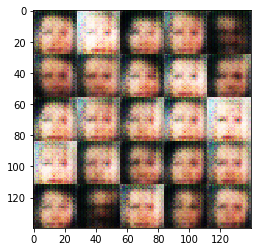

Epoch 1/5... Discriminator Loss: 1.5824... Generator Loss: 1.1578...
Epoch 1/5... Discriminator Loss: 1.8229... Generator Loss: 0.5938...
Epoch 1/5... Discriminator Loss: 2.7085... Generator Loss: 0.6596...
Epoch 1/5... Discriminator Loss: 1.7469... Generator Loss: 0.6833...
Epoch 1/5... Discriminator Loss: 1.5976... Generator Loss: 0.8611...
Epoch 1/5... Discriminator Loss: 1.7528... Generator Loss: 0.7296...
Epoch 1/5... Discriminator Loss: 1.5530... Generator Loss: 0.7513...
Epoch 1/5... Discriminator Loss: 1.5434... Generator Loss: 0.9562...
Epoch 1/5... Discriminator Loss: 1.4782... Generator Loss: 0.9094...
Epoch 1/5... Discriminator Loss: 1.7125... Generator Loss: 0.6241...


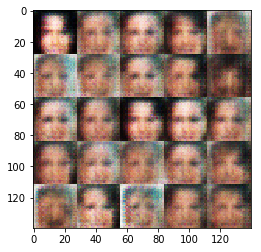

Epoch 1/5... Discriminator Loss: 1.7152... Generator Loss: 1.0238...
Epoch 1/5... Discriminator Loss: 1.5870... Generator Loss: 0.8257...
Epoch 1/5... Discriminator Loss: 1.7868... Generator Loss: 0.6398...
Epoch 1/5... Discriminator Loss: 1.5456... Generator Loss: 0.7622...
Epoch 1/5... Discriminator Loss: 1.6352... Generator Loss: 0.8335...
Epoch 1/5... Discriminator Loss: 1.6018... Generator Loss: 0.8809...
Epoch 1/5... Discriminator Loss: 1.5489... Generator Loss: 0.8178...
Epoch 1/5... Discriminator Loss: 1.5658... Generator Loss: 0.8522...
Epoch 1/5... Discriminator Loss: 1.5918... Generator Loss: 0.8275...
Epoch 1/5... Discriminator Loss: 1.5590... Generator Loss: 0.8417...


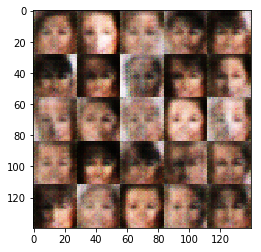

Epoch 1/5... Discriminator Loss: 1.4662... Generator Loss: 0.7429...
Epoch 1/5... Discriminator Loss: 1.4976... Generator Loss: 0.8635...
Epoch 1/5... Discriminator Loss: 1.7592... Generator Loss: 0.8190...
Epoch 1/5... Discriminator Loss: 1.4766... Generator Loss: 0.8253...
Epoch 1/5... Discriminator Loss: 1.6477... Generator Loss: 0.8436...
Epoch 1/5... Discriminator Loss: 1.4286... Generator Loss: 0.9958...
Epoch 1/5... Discriminator Loss: 1.5925... Generator Loss: 0.7265...
Epoch 1/5... Discriminator Loss: 1.7094... Generator Loss: 0.7949...
Epoch 1/5... Discriminator Loss: 1.6824... Generator Loss: 0.8791...
Epoch 1/5... Discriminator Loss: 1.4572... Generator Loss: 0.7681...


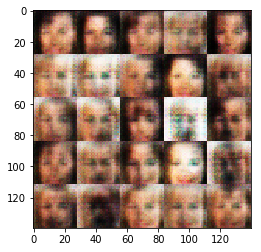

Epoch 1/5... Discriminator Loss: 1.3254... Generator Loss: 0.7698...
Epoch 1/5... Discriminator Loss: 1.7906... Generator Loss: 0.7778...
Epoch 1/5... Discriminator Loss: 1.4897... Generator Loss: 0.8626...
Epoch 1/5... Discriminator Loss: 1.6125... Generator Loss: 0.8154...
Epoch 1/5... Discriminator Loss: 1.3440... Generator Loss: 0.9653...
Epoch 1/5... Discriminator Loss: 1.6134... Generator Loss: 0.8159...
Epoch 1/5... Discriminator Loss: 1.4213... Generator Loss: 0.8703...
Epoch 1/5... Discriminator Loss: 1.6094... Generator Loss: 0.9000...
Epoch 1/5... Discriminator Loss: 1.4914... Generator Loss: 0.8320...
Epoch 1/5... Discriminator Loss: 1.6202... Generator Loss: 0.8612...


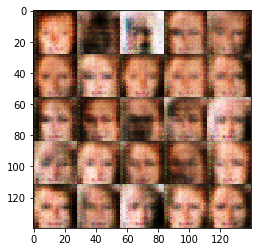

Epoch 1/5... Discriminator Loss: 1.4588... Generator Loss: 0.8454...
Epoch 1/5... Discriminator Loss: 1.7353... Generator Loss: 0.8097...
Epoch 1/5... Discriminator Loss: 1.5022... Generator Loss: 0.7687...
Epoch 1/5... Discriminator Loss: 1.5640... Generator Loss: 0.8504...
Epoch 1/5... Discriminator Loss: 1.4084... Generator Loss: 0.8614...
Epoch 1/5... Discriminator Loss: 1.5331... Generator Loss: 0.8756...
Epoch 1/5... Discriminator Loss: 1.6331... Generator Loss: 0.7661...
Epoch 1/5... Discriminator Loss: 1.5729... Generator Loss: 0.8499...
Epoch 1/5... Discriminator Loss: 1.4571... Generator Loss: 0.9946...
Epoch 1/5... Discriminator Loss: 1.4856... Generator Loss: 0.8185...


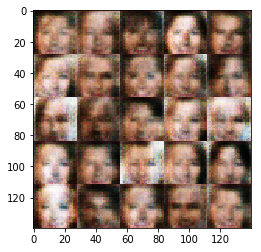

Epoch 1/5... Discriminator Loss: 1.5765... Generator Loss: 0.7466...
Epoch 1/5... Discriminator Loss: 1.5079... Generator Loss: 0.7827...
Epoch 1/5... Discriminator Loss: 1.5779... Generator Loss: 0.7555...
Epoch 1/5... Discriminator Loss: 1.4810... Generator Loss: 0.8469...
Epoch 1/5... Discriminator Loss: 1.4890... Generator Loss: 0.7933...
Epoch 1/5... Discriminator Loss: 1.4671... Generator Loss: 0.8278...
Epoch 1/5... Discriminator Loss: 1.4360... Generator Loss: 0.9092...
Epoch 1/5... Discriminator Loss: 1.4814... Generator Loss: 0.8804...
Epoch 1/5... Discriminator Loss: 1.4826... Generator Loss: 0.7020...
Epoch 1/5... Discriminator Loss: 1.4658... Generator Loss: 0.8423...


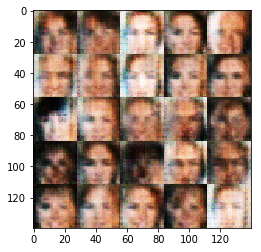

Epoch 1/5... Discriminator Loss: 1.4678... Generator Loss: 0.8691...
Epoch 1/5... Discriminator Loss: 1.4336... Generator Loss: 0.8699...
Epoch 1/5... Discriminator Loss: 1.5035... Generator Loss: 0.8108...
Epoch 1/5... Discriminator Loss: 1.4613... Generator Loss: 0.8367...
Epoch 1/5... Discriminator Loss: 1.4993... Generator Loss: 0.7939...
Epoch 1/5... Discriminator Loss: 1.5764... Generator Loss: 0.8252...
Epoch 1/5... Discriminator Loss: 1.5689... Generator Loss: 0.8010...
Epoch 1/5... Discriminator Loss: 1.5000... Generator Loss: 0.8371...
Epoch 1/5... Discriminator Loss: 1.4128... Generator Loss: 0.7918...
Epoch 1/5... Discriminator Loss: 1.5481... Generator Loss: 0.8145...


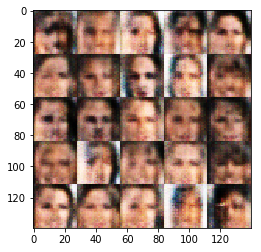

Epoch 1/5... Discriminator Loss: 1.5340... Generator Loss: 0.7641...
Epoch 1/5... Discriminator Loss: 1.5232... Generator Loss: 0.8309...
Epoch 1/5... Discriminator Loss: 1.5483... Generator Loss: 0.7031...
Epoch 1/5... Discriminator Loss: 1.4873... Generator Loss: 0.7613...
Epoch 1/5... Discriminator Loss: 1.5165... Generator Loss: 0.8344...
Epoch 1/5... Discriminator Loss: 1.4075... Generator Loss: 0.7662...
Epoch 1/5... Discriminator Loss: 1.4646... Generator Loss: 0.9919...
Epoch 1/5... Discriminator Loss: 1.4983... Generator Loss: 0.8098...
Epoch 1/5... Discriminator Loss: 1.5163... Generator Loss: 0.8101...
Epoch 1/5... Discriminator Loss: 1.4918... Generator Loss: 0.8561...


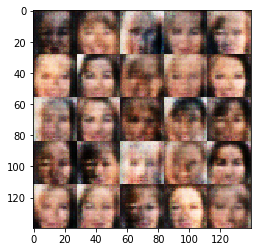

Epoch 1/5... Discriminator Loss: 1.5593... Generator Loss: 0.7768...
Epoch 1/5... Discriminator Loss: 1.4045... Generator Loss: 0.8618...
Epoch 1/5... Discriminator Loss: 1.4897... Generator Loss: 0.8103...
Epoch 1/5... Discriminator Loss: 1.4574... Generator Loss: 0.8187...
Epoch 1/5... Discriminator Loss: 1.4687... Generator Loss: 0.8016...
Epoch 1/5... Discriminator Loss: 1.5164... Generator Loss: 0.7744...
Epoch 1/5... Discriminator Loss: 1.4548... Generator Loss: 0.7480...
Epoch 1/5... Discriminator Loss: 1.4079... Generator Loss: 0.8248...
Epoch 1/5... Discriminator Loss: 1.5676... Generator Loss: 0.8517...
Epoch 1/5... Discriminator Loss: 1.4994... Generator Loss: 0.8535...


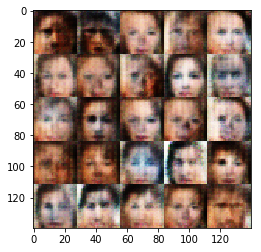

Epoch 1/5... Discriminator Loss: 1.5507... Generator Loss: 0.7066...
Epoch 1/5... Discriminator Loss: 1.5866... Generator Loss: 0.8867...
Epoch 1/5... Discriminator Loss: 1.4235... Generator Loss: 0.8447...
Epoch 1/5... Discriminator Loss: 1.4918... Generator Loss: 0.8033...
Epoch 1/5... Discriminator Loss: 1.4638... Generator Loss: 0.8972...
Epoch 1/5... Discriminator Loss: 1.4624... Generator Loss: 0.7976...
Epoch 1/5... Discriminator Loss: 1.5377... Generator Loss: 0.7269...
Epoch 1/5... Discriminator Loss: 1.4762... Generator Loss: 0.8343...
Epoch 1/5... Discriminator Loss: 1.4002... Generator Loss: 0.8205...
Epoch 1/5... Discriminator Loss: 1.4840... Generator Loss: 0.8019...


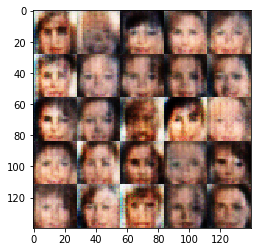

Epoch 1/5... Discriminator Loss: 1.4893... Generator Loss: 0.7444...
Epoch 1/5... Discriminator Loss: 1.5848... Generator Loss: 0.7144...
Epoch 1/5... Discriminator Loss: 1.4233... Generator Loss: 0.8270...
Epoch 1/5... Discriminator Loss: 1.4859... Generator Loss: 0.7820...
Epoch 1/5... Discriminator Loss: 1.3954... Generator Loss: 0.7685...
Epoch 1/5... Discriminator Loss: 1.5064... Generator Loss: 0.8326...
Epoch 1/5... Discriminator Loss: 1.4437... Generator Loss: 0.8338...
Epoch 1/5... Discriminator Loss: 1.4187... Generator Loss: 0.7679...
Epoch 1/5... Discriminator Loss: 1.4237... Generator Loss: 0.8091...
Epoch 1/5... Discriminator Loss: 1.4771... Generator Loss: 0.8254...


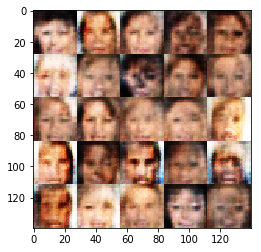

Epoch 1/5... Discriminator Loss: 1.4266... Generator Loss: 0.8922...
Epoch 1/5... Discriminator Loss: 1.4781... Generator Loss: 0.8855...
Epoch 1/5... Discriminator Loss: 1.4915... Generator Loss: 0.7721...
Epoch 1/5... Discriminator Loss: 1.4778... Generator Loss: 0.7649...
Epoch 1/5... Discriminator Loss: 1.4947... Generator Loss: 0.7747...
Epoch 1/5... Discriminator Loss: 1.4666... Generator Loss: 0.6620...
Epoch 1/5... Discriminator Loss: 1.4775... Generator Loss: 0.7602...
Epoch 1/5... Discriminator Loss: 1.4394... Generator Loss: 0.8785...
Epoch 1/5... Discriminator Loss: 1.4118... Generator Loss: 0.7912...
Epoch 1/5... Discriminator Loss: 1.4580... Generator Loss: 0.8949...


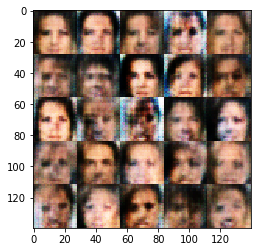

Epoch 1/5... Discriminator Loss: 1.5117... Generator Loss: 0.7311...
Epoch 1/5... Discriminator Loss: 1.4476... Generator Loss: 0.8930...
Epoch 1/5... Discriminator Loss: 1.4754... Generator Loss: 0.7695...
Epoch 1/5... Discriminator Loss: 1.3841... Generator Loss: 0.8295...
Epoch 1/5... Discriminator Loss: 1.5944... Generator Loss: 0.7751...
Epoch 1/5... Discriminator Loss: 1.4714... Generator Loss: 0.8429...
Epoch 1/5... Discriminator Loss: 1.4487... Generator Loss: 0.7753...
Epoch 1/5... Discriminator Loss: 1.4228... Generator Loss: 0.7338...
Epoch 1/5... Discriminator Loss: 1.4792... Generator Loss: 0.8216...
Epoch 1/5... Discriminator Loss: 1.3476... Generator Loss: 0.8302...


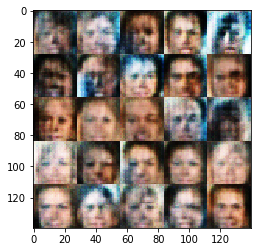

Epoch 1/5... Discriminator Loss: 1.4577... Generator Loss: 0.7124...
Epoch 1/5... Discriminator Loss: 1.4922... Generator Loss: 0.8162...
Epoch 1/5... Discriminator Loss: 1.5601... Generator Loss: 0.8280...
Epoch 1/5... Discriminator Loss: 1.4739... Generator Loss: 0.8978...
Epoch 1/5... Discriminator Loss: 1.4782... Generator Loss: 0.7490...
Epoch 1/5... Discriminator Loss: 1.5165... Generator Loss: 0.8454...
Epoch 1/5... Discriminator Loss: 1.4157... Generator Loss: 0.8736...
Epoch 1/5... Discriminator Loss: 1.4463... Generator Loss: 0.7645...
Epoch 1/5... Discriminator Loss: 1.4587... Generator Loss: 0.8192...
Epoch 1/5... Discriminator Loss: 1.4684... Generator Loss: 0.8212...


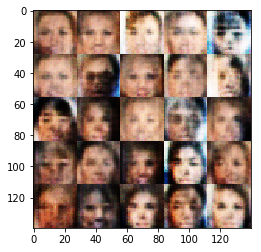

Epoch 1/5... Discriminator Loss: 1.4263... Generator Loss: 0.8348...
Epoch 1/5... Discriminator Loss: 1.4332... Generator Loss: 0.8111...
Epoch 1/5... Discriminator Loss: 1.4426... Generator Loss: 0.7479...
Epoch 1/5... Discriminator Loss: 1.4673... Generator Loss: 0.7973...
Epoch 1/5... Discriminator Loss: 1.4048... Generator Loss: 0.8637...
Epoch 1/5... Discriminator Loss: 1.5176... Generator Loss: 0.7278...
Epoch 1/5... Discriminator Loss: 1.4018... Generator Loss: 0.7253...
Epoch 1/5... Discriminator Loss: 1.4679... Generator Loss: 0.7975...
Epoch 1/5... Discriminator Loss: 1.4903... Generator Loss: 0.7667...
Epoch 1/5... Discriminator Loss: 1.4033... Generator Loss: 0.7164...


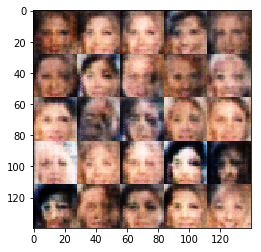

Epoch 1/5... Discriminator Loss: 1.5248... Generator Loss: 0.7932...
Epoch 1/5... Discriminator Loss: 1.4115... Generator Loss: 0.8041...
Epoch 1/5... Discriminator Loss: 1.3898... Generator Loss: 0.8614...
Epoch 1/5... Discriminator Loss: 1.5151... Generator Loss: 0.6962...
Epoch 1/5... Discriminator Loss: 1.4721... Generator Loss: 0.8706...
Epoch 1/5... Discriminator Loss: 1.5128... Generator Loss: 0.7520...
Epoch 1/5... Discriminator Loss: 1.4298... Generator Loss: 0.8520...
Epoch 1/5... Discriminator Loss: 1.4200... Generator Loss: 0.7698...
Epoch 1/5... Discriminator Loss: 1.4496... Generator Loss: 0.7620...
Epoch 1/5... Discriminator Loss: 1.4414... Generator Loss: 0.8781...


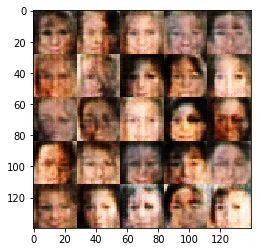

Epoch 1/5... Discriminator Loss: 1.4415... Generator Loss: 0.8268...
Epoch 1/5... Discriminator Loss: 1.4910... Generator Loss: 0.8024...
Epoch 1/5... Discriminator Loss: 1.4108... Generator Loss: 0.8157...
Epoch 1/5... Discriminator Loss: 1.4435... Generator Loss: 0.8425...
Epoch 1/5... Discriminator Loss: 1.3866... Generator Loss: 0.8155...
Epoch 1/5... Discriminator Loss: 1.3980... Generator Loss: 0.7688...
Epoch 1/5... Discriminator Loss: 1.4374... Generator Loss: 0.7488...
Epoch 1/5... Discriminator Loss: 1.4572... Generator Loss: 0.8358...
Epoch 1/5... Discriminator Loss: 1.4819... Generator Loss: 0.8211...
Epoch 1/5... Discriminator Loss: 1.4399... Generator Loss: 0.8564...


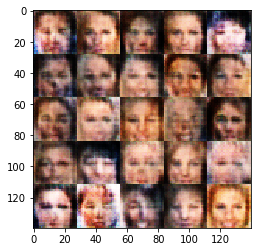

Epoch 1/5... Discriminator Loss: 1.3702... Generator Loss: 0.7773...
Epoch 1/5... Discriminator Loss: 1.3751... Generator Loss: 0.8241...
Epoch 1/5... Discriminator Loss: 1.4243... Generator Loss: 0.7824...
Epoch 1/5... Discriminator Loss: 1.4549... Generator Loss: 0.7664...
Epoch 1/5... Discriminator Loss: 1.3596... Generator Loss: 0.9394...
Epoch 1/5... Discriminator Loss: 1.4344... Generator Loss: 0.8897...
Epoch 1/5... Discriminator Loss: 1.4458... Generator Loss: 0.7188...
Epoch 1/5... Discriminator Loss: 1.4226... Generator Loss: 0.9345...
Epoch 1/5... Discriminator Loss: 1.5103... Generator Loss: 0.7926...
Epoch 1/5... Discriminator Loss: 1.4288... Generator Loss: 0.7537...


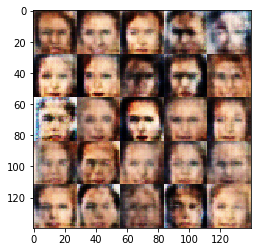

Epoch 1/5... Discriminator Loss: 1.5214... Generator Loss: 0.7615...
Epoch 1/5... Discriminator Loss: 1.4088... Generator Loss: 0.8395...
Epoch 1/5... Discriminator Loss: 1.4546... Generator Loss: 0.7395...
Epoch 1/5... Discriminator Loss: 1.4645... Generator Loss: 0.9127...
Epoch 1/5... Discriminator Loss: 1.4967... Generator Loss: 0.7883...
Epoch 1/5... Discriminator Loss: 1.4965... Generator Loss: 0.8405...
Epoch 1/5... Discriminator Loss: 1.4355... Generator Loss: 0.8118...
Epoch 1/5... Discriminator Loss: 1.4046... Generator Loss: 0.7273...
Epoch 1/5... Discriminator Loss: 1.3775... Generator Loss: 0.8328...
Epoch 1/5... Discriminator Loss: 1.4035... Generator Loss: 0.8016...


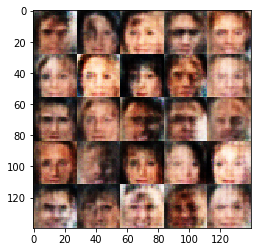

Epoch 1/5... Discriminator Loss: 1.4129... Generator Loss: 0.7772...
Epoch 1/5... Discriminator Loss: 1.4745... Generator Loss: 0.7312...
Epoch 1/5... Discriminator Loss: 1.4328... Generator Loss: 0.8723...
Epoch 1/5... Discriminator Loss: 1.3960... Generator Loss: 0.8548...
Epoch 1/5... Discriminator Loss: 1.4933... Generator Loss: 0.8059...
Epoch 1/5... Discriminator Loss: 1.4506... Generator Loss: 0.7838...
Epoch 1/5... Discriminator Loss: 1.4598... Generator Loss: 0.8694...
Epoch 1/5... Discriminator Loss: 1.4054... Generator Loss: 0.7829...
Epoch 1/5... Discriminator Loss: 1.4282... Generator Loss: 0.7523...
Epoch 1/5... Discriminator Loss: 1.4222... Generator Loss: 0.8459...


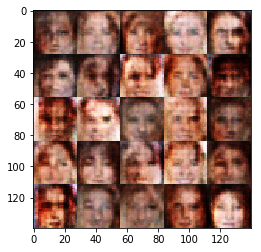

Epoch 1/5... Discriminator Loss: 1.3787... Generator Loss: 0.8013...
Epoch 1/5... Discriminator Loss: 1.3921... Generator Loss: 0.8058...
Epoch 1/5... Discriminator Loss: 1.4099... Generator Loss: 0.7475...
Epoch 1/5... Discriminator Loss: 1.4389... Generator Loss: 0.7142...
Epoch 1/5... Discriminator Loss: 1.4596... Generator Loss: 0.7301...
Epoch 1/5... Discriminator Loss: 1.3611... Generator Loss: 0.8027...
Epoch 1/5... Discriminator Loss: 1.5196... Generator Loss: 0.7940...
Epoch 1/5... Discriminator Loss: 1.5900... Generator Loss: 0.6773...
Epoch 1/5... Discriminator Loss: 1.3624... Generator Loss: 0.8364...
Epoch 1/5... Discriminator Loss: 1.4878... Generator Loss: 0.8943...


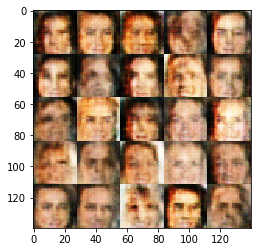

Epoch 1/5... Discriminator Loss: 1.4333... Generator Loss: 0.7347...
Epoch 1/5... Discriminator Loss: 1.3974... Generator Loss: 0.7961...
Epoch 1/5... Discriminator Loss: 1.4134... Generator Loss: 0.7842...
Epoch 1/5... Discriminator Loss: 1.3584... Generator Loss: 0.8560...
Epoch 1/5... Discriminator Loss: 1.4333... Generator Loss: 0.7438...
Epoch 1/5... Discriminator Loss: 1.3999... Generator Loss: 0.7541...
Epoch 1/5... Discriminator Loss: 1.4201... Generator Loss: 0.7924...
Epoch 1/5... Discriminator Loss: 1.4154... Generator Loss: 0.8296...
Epoch 1/5... Discriminator Loss: 1.5167... Generator Loss: 0.8018...
Epoch 1/5... Discriminator Loss: 1.4137... Generator Loss: 0.8273...


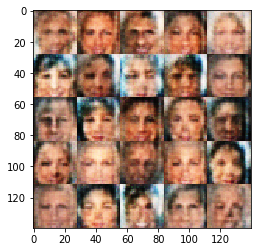

Epoch 1/5... Discriminator Loss: 1.5055... Generator Loss: 0.7348...
Epoch 1/5... Discriminator Loss: 1.4222... Generator Loss: 0.8053...
Epoch 1/5... Discriminator Loss: 1.4878... Generator Loss: 0.6853...
Epoch 1/5... Discriminator Loss: 1.4671... Generator Loss: 0.8758...
Epoch 1/5... Discriminator Loss: 1.4552... Generator Loss: 0.8260...
Epoch 1/5... Discriminator Loss: 1.3622... Generator Loss: 0.7979...
Epoch 1/5... Discriminator Loss: 1.4026... Generator Loss: 0.7579...
Epoch 1/5... Discriminator Loss: 1.4328... Generator Loss: 0.8346...
Epoch 1/5... Discriminator Loss: 1.4277... Generator Loss: 0.7664...
Epoch 1/5... Discriminator Loss: 1.4418... Generator Loss: 0.7695...


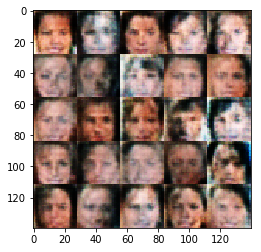

Epoch 1/5... Discriminator Loss: 1.4115... Generator Loss: 0.8140...
Epoch 1/5... Discriminator Loss: 1.3928... Generator Loss: 0.8068...
Epoch 1/5... Discriminator Loss: 1.4388... Generator Loss: 0.8130...
Epoch 1/5... Discriminator Loss: 1.4413... Generator Loss: 0.7566...
Epoch 1/5... Discriminator Loss: 1.4477... Generator Loss: 0.7836...
Epoch 1/5... Discriminator Loss: 1.4874... Generator Loss: 0.8275...
Epoch 1/5... Discriminator Loss: 1.5052... Generator Loss: 0.6806...
Epoch 1/5... Discriminator Loss: 1.4190... Generator Loss: 0.8457...
Epoch 1/5... Discriminator Loss: 1.4047... Generator Loss: 0.8107...
Epoch 1/5... Discriminator Loss: 1.3953... Generator Loss: 0.8254...


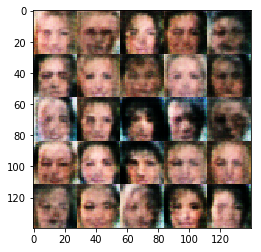

Epoch 1/5... Discriminator Loss: 1.3944... Generator Loss: 0.7627...
Epoch 1/5... Discriminator Loss: 1.4377... Generator Loss: 0.8399...
Epoch 1/5... Discriminator Loss: 1.4634... Generator Loss: 0.8358...
Epoch 1/5... Discriminator Loss: 1.4565... Generator Loss: 0.7606...
Epoch 1/5... Discriminator Loss: 1.4106... Generator Loss: 0.8383...
Epoch 1/5... Discriminator Loss: 1.4067... Generator Loss: 0.7309...
Epoch 1/5... Discriminator Loss: 1.4329... Generator Loss: 0.7848...
Epoch 1/5... Discriminator Loss: 1.4021... Generator Loss: 0.6979...
Epoch 1/5... Discriminator Loss: 1.4623... Generator Loss: 0.9929...
Epoch 1/5... Discriminator Loss: 1.4653... Generator Loss: 0.8153...


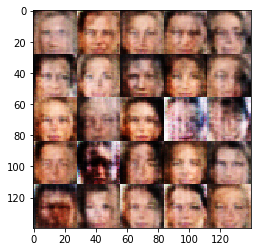

Epoch 1/5... Discriminator Loss: 1.3643... Generator Loss: 0.8126...
Epoch 1/5... Discriminator Loss: 1.4644... Generator Loss: 0.9293...
Epoch 1/5... Discriminator Loss: 1.4301... Generator Loss: 0.9363...
Epoch 1/5... Discriminator Loss: 1.4199... Generator Loss: 0.7555...
Epoch 1/5... Discriminator Loss: 1.4325... Generator Loss: 0.7879...
Epoch 1/5... Discriminator Loss: 1.4287... Generator Loss: 0.7028...
Epoch 1/5... Discriminator Loss: 1.5013... Generator Loss: 0.6925...
Epoch 1/5... Discriminator Loss: 1.4271... Generator Loss: 0.7585...
Epoch 1/5... Discriminator Loss: 1.4308... Generator Loss: 0.8899...
Epoch 1/5... Discriminator Loss: 1.4098... Generator Loss: 0.8602...


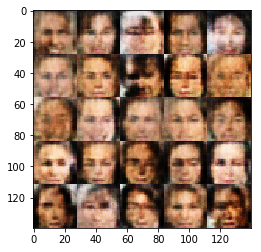

Epoch 1/5... Discriminator Loss: 1.4049... Generator Loss: 0.8423...
Epoch 1/5... Discriminator Loss: 1.4510... Generator Loss: 0.8743...
Epoch 1/5... Discriminator Loss: 1.3544... Generator Loss: 0.8115...
Epoch 1/5... Discriminator Loss: 1.4525... Generator Loss: 0.7869...
Epoch 1/5... Discriminator Loss: 1.4634... Generator Loss: 0.7994...
Epoch 1/5... Discriminator Loss: 1.3791... Generator Loss: 0.7275...
Epoch 1/5... Discriminator Loss: 1.4773... Generator Loss: 0.7710...
Epoch 1/5... Discriminator Loss: 1.4781... Generator Loss: 0.7398...
Epoch 1/5... Discriminator Loss: 1.4852... Generator Loss: 0.8282...
Epoch 1/5... Discriminator Loss: 1.4313... Generator Loss: 0.8676...


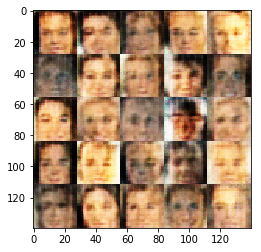

Epoch 1/5... Discriminator Loss: 1.4670... Generator Loss: 0.8122...
Epoch 1/5... Discriminator Loss: 1.4159... Generator Loss: 0.7018...
Epoch 1/5... Discriminator Loss: 1.4421... Generator Loss: 0.9265...
Epoch 1/5... Discriminator Loss: 1.4141... Generator Loss: 0.7747...
Epoch 1/5... Discriminator Loss: 1.3900... Generator Loss: 0.7025...
Epoch 1/5... Discriminator Loss: 1.4756... Generator Loss: 0.7262...
Epoch 1/5... Discriminator Loss: 1.4135... Generator Loss: 0.8676...
Epoch 1/5... Discriminator Loss: 1.4010... Generator Loss: 0.7778...
Epoch 1/5... Discriminator Loss: 1.3929... Generator Loss: 0.9793...
Epoch 1/5... Discriminator Loss: 1.4198... Generator Loss: 0.7424...


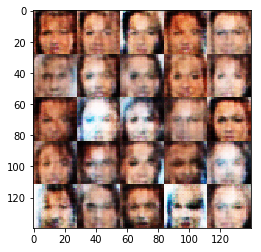

Epoch 1/5... Discriminator Loss: 1.4377... Generator Loss: 0.8099...
Epoch 1/5... Discriminator Loss: 1.3589... Generator Loss: 0.8892...
Epoch 1/5... Discriminator Loss: 1.4439... Generator Loss: 0.7852...
Epoch 1/5... Discriminator Loss: 1.4275... Generator Loss: 0.8064...
Epoch 1/5... Discriminator Loss: 1.4389... Generator Loss: 0.8612...
Epoch 1/5... Discriminator Loss: 1.4430... Generator Loss: 0.9085...
Epoch 2/5... Discriminator Loss: 1.4705... Generator Loss: 0.8438...
Epoch 2/5... Discriminator Loss: 1.4227... Generator Loss: 0.8688...
Epoch 2/5... Discriminator Loss: 1.4237... Generator Loss: 0.7633...
Epoch 2/5... Discriminator Loss: 1.4229... Generator Loss: 0.8112...


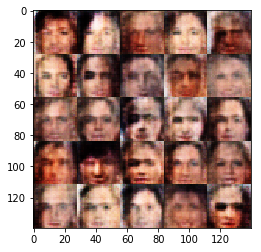

Epoch 2/5... Discriminator Loss: 1.4017... Generator Loss: 0.8079...
Epoch 2/5... Discriminator Loss: 1.3921... Generator Loss: 0.8817...
Epoch 2/5... Discriminator Loss: 1.3819... Generator Loss: 0.7652...
Epoch 2/5... Discriminator Loss: 1.4481... Generator Loss: 0.7558...
Epoch 2/5... Discriminator Loss: 1.4486... Generator Loss: 0.8286...
Epoch 2/5... Discriminator Loss: 1.4473... Generator Loss: 0.7831...
Epoch 2/5... Discriminator Loss: 1.4216... Generator Loss: 0.8282...
Epoch 2/5... Discriminator Loss: 1.4377... Generator Loss: 0.7869...
Epoch 2/5... Discriminator Loss: 1.3987... Generator Loss: 0.8802...
Epoch 2/5... Discriminator Loss: 1.4643... Generator Loss: 0.7232...


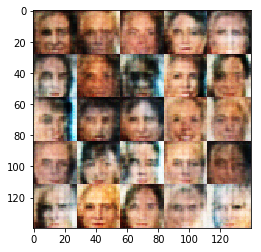

Epoch 2/5... Discriminator Loss: 1.4087... Generator Loss: 0.7061...
Epoch 2/5... Discriminator Loss: 1.4296... Generator Loss: 0.7970...
Epoch 2/5... Discriminator Loss: 1.4027... Generator Loss: 0.8148...
Epoch 2/5... Discriminator Loss: 1.3984... Generator Loss: 0.7632...
Epoch 2/5... Discriminator Loss: 1.4184... Generator Loss: 0.7226...
Epoch 2/5... Discriminator Loss: 1.4485... Generator Loss: 0.7536...
Epoch 2/5... Discriminator Loss: 1.3593... Generator Loss: 0.8400...
Epoch 2/5... Discriminator Loss: 1.4796... Generator Loss: 0.7886...
Epoch 2/5... Discriminator Loss: 1.4248... Generator Loss: 0.7954...
Epoch 2/5... Discriminator Loss: 1.4014... Generator Loss: 0.8348...


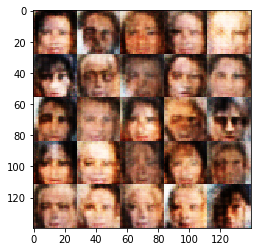

Epoch 2/5... Discriminator Loss: 1.3990... Generator Loss: 0.8520...
Epoch 2/5... Discriminator Loss: 1.4480... Generator Loss: 0.7458...
Epoch 2/5... Discriminator Loss: 1.4580... Generator Loss: 0.7301...
Epoch 2/5... Discriminator Loss: 1.4659... Generator Loss: 1.0076...
Epoch 2/5... Discriminator Loss: 1.5201... Generator Loss: 0.7264...
Epoch 2/5... Discriminator Loss: 1.3772... Generator Loss: 0.8264...
Epoch 2/5... Discriminator Loss: 1.4496... Generator Loss: 0.7530...
Epoch 2/5... Discriminator Loss: 1.4494... Generator Loss: 0.8161...
Epoch 2/5... Discriminator Loss: 1.3828... Generator Loss: 0.8009...
Epoch 2/5... Discriminator Loss: 1.4049... Generator Loss: 0.7820...


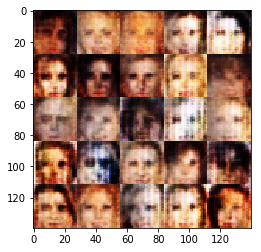

Epoch 2/5... Discriminator Loss: 1.4081... Generator Loss: 0.7567...
Epoch 2/5... Discriminator Loss: 1.4574... Generator Loss: 0.7072...
Epoch 2/5... Discriminator Loss: 1.3380... Generator Loss: 0.8108...
Epoch 2/5... Discriminator Loss: 1.4193... Generator Loss: 0.7908...
Epoch 2/5... Discriminator Loss: 1.4102... Generator Loss: 0.8111...
Epoch 2/5... Discriminator Loss: 1.3893... Generator Loss: 0.7478...
Epoch 2/5... Discriminator Loss: 1.4224... Generator Loss: 0.8642...
Epoch 2/5... Discriminator Loss: 1.4526... Generator Loss: 0.8575...
Epoch 2/5... Discriminator Loss: 1.4342... Generator Loss: 0.8556...
Epoch 2/5... Discriminator Loss: 1.4353... Generator Loss: 0.7850...


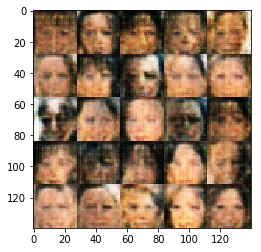

Epoch 2/5... Discriminator Loss: 1.3836... Generator Loss: 0.6908...
Epoch 2/5... Discriminator Loss: 1.5157... Generator Loss: 0.7385...
Epoch 2/5... Discriminator Loss: 1.4369... Generator Loss: 0.7142...
Epoch 2/5... Discriminator Loss: 1.5012... Generator Loss: 0.8437...
Epoch 2/5... Discriminator Loss: 1.4011... Generator Loss: 0.9918...
Epoch 2/5... Discriminator Loss: 1.3554... Generator Loss: 0.7945...
Epoch 2/5... Discriminator Loss: 1.4065... Generator Loss: 0.7792...
Epoch 2/5... Discriminator Loss: 1.3806... Generator Loss: 0.7917...
Epoch 2/5... Discriminator Loss: 1.4667... Generator Loss: 0.7004...
Epoch 2/5... Discriminator Loss: 1.4050... Generator Loss: 0.7192...


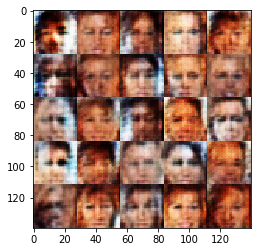

Epoch 2/5... Discriminator Loss: 1.4330... Generator Loss: 0.8078...
Epoch 2/5... Discriminator Loss: 1.4618... Generator Loss: 0.7497...
Epoch 2/5... Discriminator Loss: 1.3934... Generator Loss: 0.9502...
Epoch 2/5... Discriminator Loss: 1.4163... Generator Loss: 0.8540...
Epoch 2/5... Discriminator Loss: 1.4860... Generator Loss: 0.7937...
Epoch 2/5... Discriminator Loss: 1.4024... Generator Loss: 0.7874...
Epoch 2/5... Discriminator Loss: 1.3917... Generator Loss: 0.8301...
Epoch 2/5... Discriminator Loss: 1.4112... Generator Loss: 0.7589...
Epoch 2/5... Discriminator Loss: 1.4011... Generator Loss: 0.8489...
Epoch 2/5... Discriminator Loss: 1.4149... Generator Loss: 0.8986...


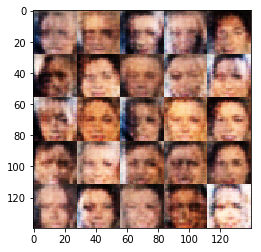

Epoch 2/5... Discriminator Loss: 1.4085... Generator Loss: 0.8194...
Epoch 2/5... Discriminator Loss: 1.4703... Generator Loss: 0.7597...
Epoch 2/5... Discriminator Loss: 1.4713... Generator Loss: 0.6324...
Epoch 2/5... Discriminator Loss: 1.3813... Generator Loss: 0.7334...
Epoch 2/5... Discriminator Loss: 1.4139... Generator Loss: 0.8790...
Epoch 2/5... Discriminator Loss: 1.4206... Generator Loss: 0.7093...
Epoch 2/5... Discriminator Loss: 1.4172... Generator Loss: 0.8779...
Epoch 2/5... Discriminator Loss: 1.4205... Generator Loss: 0.7749...
Epoch 2/5... Discriminator Loss: 1.4908... Generator Loss: 0.7042...
Epoch 2/5... Discriminator Loss: 1.4323... Generator Loss: 0.8809...


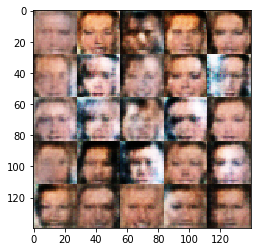

Epoch 2/5... Discriminator Loss: 1.5333... Generator Loss: 0.7449...
Epoch 2/5... Discriminator Loss: 1.4494... Generator Loss: 0.8151...
Epoch 2/5... Discriminator Loss: 1.4245... Generator Loss: 0.9054...
Epoch 2/5... Discriminator Loss: 1.3942... Generator Loss: 0.8690...
Epoch 2/5... Discriminator Loss: 1.4336... Generator Loss: 0.7575...
Epoch 2/5... Discriminator Loss: 1.4149... Generator Loss: 0.8424...
Epoch 2/5... Discriminator Loss: 1.3893... Generator Loss: 0.9648...
Epoch 2/5... Discriminator Loss: 1.3839... Generator Loss: 0.7739...
Epoch 2/5... Discriminator Loss: 1.4618... Generator Loss: 0.8352...
Epoch 2/5... Discriminator Loss: 1.4264... Generator Loss: 0.8403...


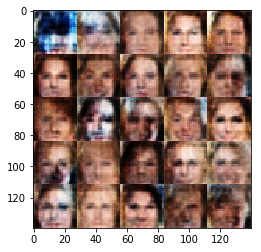

Epoch 2/5... Discriminator Loss: 1.3977... Generator Loss: 0.7801...
Epoch 2/5... Discriminator Loss: 1.4477... Generator Loss: 0.8031...
Epoch 2/5... Discriminator Loss: 1.4448... Generator Loss: 0.8188...
Epoch 2/5... Discriminator Loss: 1.3970... Generator Loss: 0.7529...
Epoch 2/5... Discriminator Loss: 1.3984... Generator Loss: 0.8762...
Epoch 2/5... Discriminator Loss: 1.3883... Generator Loss: 0.7576...
Epoch 2/5... Discriminator Loss: 1.4174... Generator Loss: 0.8446...
Epoch 2/5... Discriminator Loss: 1.4232... Generator Loss: 0.7816...
Epoch 2/5... Discriminator Loss: 1.3941... Generator Loss: 0.8121...
Epoch 2/5... Discriminator Loss: 1.4563... Generator Loss: 0.7672...


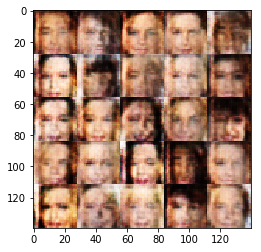

Epoch 2/5... Discriminator Loss: 1.3615... Generator Loss: 0.9371...
Epoch 2/5... Discriminator Loss: 1.4153... Generator Loss: 0.7148...
Epoch 2/5... Discriminator Loss: 1.4311... Generator Loss: 0.7976...
Epoch 2/5... Discriminator Loss: 1.4532... Generator Loss: 0.8782...
Epoch 2/5... Discriminator Loss: 1.3901... Generator Loss: 0.9289...
Epoch 2/5... Discriminator Loss: 1.4729... Generator Loss: 0.7284...
Epoch 2/5... Discriminator Loss: 1.4215... Generator Loss: 0.7731...
Epoch 2/5... Discriminator Loss: 1.4682... Generator Loss: 0.7635...
Epoch 2/5... Discriminator Loss: 1.4132... Generator Loss: 0.9721...
Epoch 2/5... Discriminator Loss: 1.4150... Generator Loss: 0.7476...


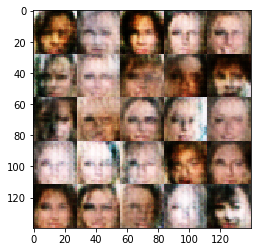

Epoch 2/5... Discriminator Loss: 1.4347... Generator Loss: 0.7678...
Epoch 2/5... Discriminator Loss: 1.3699... Generator Loss: 0.8889...
Epoch 2/5... Discriminator Loss: 1.3927... Generator Loss: 0.7306...
Epoch 2/5... Discriminator Loss: 1.3678... Generator Loss: 0.9223...
Epoch 2/5... Discriminator Loss: 1.4310... Generator Loss: 0.7265...
Epoch 2/5... Discriminator Loss: 1.4091... Generator Loss: 0.8145...
Epoch 2/5... Discriminator Loss: 1.4837... Generator Loss: 0.6916...
Epoch 2/5... Discriminator Loss: 1.4016... Generator Loss: 0.8519...
Epoch 2/5... Discriminator Loss: 1.4991... Generator Loss: 0.6846...
Epoch 2/5... Discriminator Loss: 1.3409... Generator Loss: 0.7751...


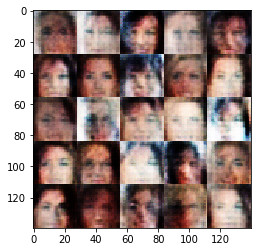

Epoch 2/5... Discriminator Loss: 1.4980... Generator Loss: 0.7860...
Epoch 2/5... Discriminator Loss: 1.3778... Generator Loss: 0.8436...
Epoch 2/5... Discriminator Loss: 1.4067... Generator Loss: 0.8467...
Epoch 2/5... Discriminator Loss: 1.3790... Generator Loss: 0.7691...
Epoch 2/5... Discriminator Loss: 1.3894... Generator Loss: 0.8241...
Epoch 2/5... Discriminator Loss: 1.4970... Generator Loss: 0.6933...
Epoch 2/5... Discriminator Loss: 1.4187... Generator Loss: 0.7752...
Epoch 2/5... Discriminator Loss: 1.3655... Generator Loss: 0.7856...
Epoch 2/5... Discriminator Loss: 1.4324... Generator Loss: 0.8655...
Epoch 2/5... Discriminator Loss: 1.4046... Generator Loss: 0.7308...


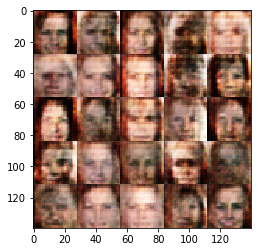

Epoch 2/5... Discriminator Loss: 1.4389... Generator Loss: 0.7853...
Epoch 2/5... Discriminator Loss: 1.3807... Generator Loss: 0.8123...
Epoch 2/5... Discriminator Loss: 1.4183... Generator Loss: 0.8101...
Epoch 2/5... Discriminator Loss: 1.4185... Generator Loss: 0.7504...
Epoch 2/5... Discriminator Loss: 1.4037... Generator Loss: 0.6766...
Epoch 2/5... Discriminator Loss: 1.3905... Generator Loss: 0.7970...
Epoch 2/5... Discriminator Loss: 1.4086... Generator Loss: 0.8292...
Epoch 2/5... Discriminator Loss: 1.4406... Generator Loss: 0.8065...
Epoch 2/5... Discriminator Loss: 1.4119... Generator Loss: 0.8574...
Epoch 2/5... Discriminator Loss: 1.4014... Generator Loss: 0.8574...


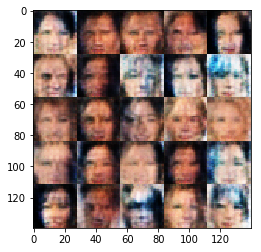

Epoch 2/5... Discriminator Loss: 1.4372... Generator Loss: 0.8356...
Epoch 2/5... Discriminator Loss: 1.3857... Generator Loss: 0.9070...
Epoch 2/5... Discriminator Loss: 1.4182... Generator Loss: 0.7711...
Epoch 2/5... Discriminator Loss: 1.4435... Generator Loss: 0.9028...
Epoch 2/5... Discriminator Loss: 1.4798... Generator Loss: 0.7704...
Epoch 2/5... Discriminator Loss: 1.3771... Generator Loss: 0.8723...
Epoch 2/5... Discriminator Loss: 1.4192... Generator Loss: 0.8385...
Epoch 2/5... Discriminator Loss: 1.4221... Generator Loss: 0.8455...
Epoch 2/5... Discriminator Loss: 1.4462... Generator Loss: 0.7826...
Epoch 2/5... Discriminator Loss: 1.4034... Generator Loss: 0.7825...


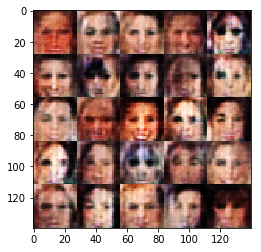

Epoch 2/5... Discriminator Loss: 1.4403... Generator Loss: 0.8671...
Epoch 2/5... Discriminator Loss: 1.3886... Generator Loss: 0.8255...
Epoch 2/5... Discriminator Loss: 1.4382... Generator Loss: 0.8664...
Epoch 2/5... Discriminator Loss: 1.4500... Generator Loss: 0.8334...
Epoch 2/5... Discriminator Loss: 1.3926... Generator Loss: 0.7548...
Epoch 2/5... Discriminator Loss: 1.4300... Generator Loss: 0.6441...
Epoch 2/5... Discriminator Loss: 1.3864... Generator Loss: 0.7714...
Epoch 2/5... Discriminator Loss: 1.4183... Generator Loss: 0.6702...
Epoch 2/5... Discriminator Loss: 1.4024... Generator Loss: 0.8917...
Epoch 2/5... Discriminator Loss: 1.4057... Generator Loss: 0.8016...


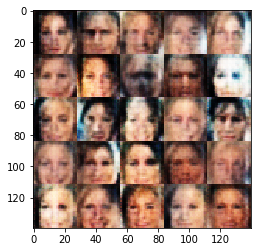

Epoch 2/5... Discriminator Loss: 1.4341... Generator Loss: 0.6713...
Epoch 2/5... Discriminator Loss: 1.3865... Generator Loss: 0.7774...
Epoch 2/5... Discriminator Loss: 1.4008... Generator Loss: 0.7790...
Epoch 2/5... Discriminator Loss: 1.4256... Generator Loss: 0.7473...
Epoch 2/5... Discriminator Loss: 1.4664... Generator Loss: 0.7680...
Epoch 2/5... Discriminator Loss: 1.4088... Generator Loss: 0.8445...
Epoch 2/5... Discriminator Loss: 1.3819... Generator Loss: 0.7798...
Epoch 2/5... Discriminator Loss: 1.3958... Generator Loss: 0.8385...
Epoch 2/5... Discriminator Loss: 1.3528... Generator Loss: 0.7055...
Epoch 2/5... Discriminator Loss: 1.4576... Generator Loss: 0.6382...


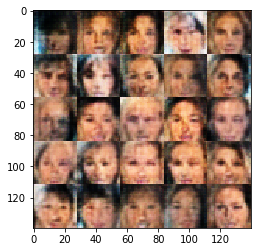

Epoch 2/5... Discriminator Loss: 1.4273... Generator Loss: 0.7993...
Epoch 2/5... Discriminator Loss: 1.4090... Generator Loss: 0.7661...
Epoch 2/5... Discriminator Loss: 1.4042... Generator Loss: 0.7914...
Epoch 2/5... Discriminator Loss: 1.4044... Generator Loss: 0.7837...
Epoch 2/5... Discriminator Loss: 1.3696... Generator Loss: 0.9219...
Epoch 2/5... Discriminator Loss: 1.3768... Generator Loss: 0.8074...
Epoch 2/5... Discriminator Loss: 1.4007... Generator Loss: 0.7390...
Epoch 2/5... Discriminator Loss: 1.4645... Generator Loss: 0.8650...
Epoch 2/5... Discriminator Loss: 1.4013... Generator Loss: 0.8467...
Epoch 2/5... Discriminator Loss: 1.3884... Generator Loss: 0.7512...


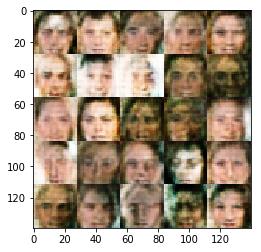

Epoch 2/5... Discriminator Loss: 1.4066... Generator Loss: 0.8020...
Epoch 2/5... Discriminator Loss: 1.4665... Generator Loss: 0.8970...
Epoch 2/5... Discriminator Loss: 1.4199... Generator Loss: 0.7775...
Epoch 2/5... Discriminator Loss: 1.4106... Generator Loss: 0.8066...
Epoch 2/5... Discriminator Loss: 1.3494... Generator Loss: 0.7755...
Epoch 2/5... Discriminator Loss: 1.4961... Generator Loss: 0.7137...
Epoch 2/5... Discriminator Loss: 1.4014... Generator Loss: 0.7255...
Epoch 2/5... Discriminator Loss: 1.3713... Generator Loss: 0.8101...
Epoch 2/5... Discriminator Loss: 1.3714... Generator Loss: 0.7902...
Epoch 2/5... Discriminator Loss: 1.3798... Generator Loss: 0.7496...


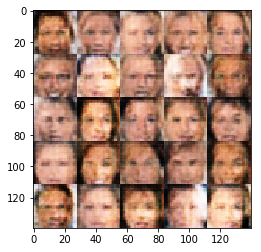

Epoch 2/5... Discriminator Loss: 1.4271... Generator Loss: 0.7704...
Epoch 2/5... Discriminator Loss: 1.3791... Generator Loss: 0.8239...
Epoch 2/5... Discriminator Loss: 1.3881... Generator Loss: 0.6540...
Epoch 2/5... Discriminator Loss: 1.4796... Generator Loss: 0.6546...
Epoch 2/5... Discriminator Loss: 1.4004... Generator Loss: 0.8090...
Epoch 2/5... Discriminator Loss: 1.3958... Generator Loss: 0.7768...
Epoch 2/5... Discriminator Loss: 1.4144... Generator Loss: 0.8120...
Epoch 2/5... Discriminator Loss: 1.4146... Generator Loss: 0.7707...
Epoch 2/5... Discriminator Loss: 1.3890... Generator Loss: 0.7670...
Epoch 2/5... Discriminator Loss: 1.4037... Generator Loss: 0.7401...


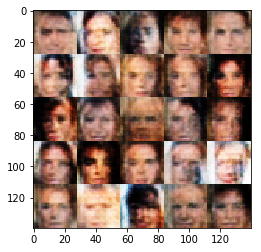

Epoch 2/5... Discriminator Loss: 1.4112... Generator Loss: 0.9381...
Epoch 2/5... Discriminator Loss: 1.4430... Generator Loss: 0.8029...
Epoch 2/5... Discriminator Loss: 1.4635... Generator Loss: 0.8011...
Epoch 2/5... Discriminator Loss: 1.4423... Generator Loss: 0.7150...
Epoch 2/5... Discriminator Loss: 1.3683... Generator Loss: 0.8716...
Epoch 2/5... Discriminator Loss: 1.3714... Generator Loss: 0.7160...
Epoch 2/5... Discriminator Loss: 1.4313... Generator Loss: 0.8031...
Epoch 2/5... Discriminator Loss: 1.3856... Generator Loss: 0.7514...
Epoch 2/5... Discriminator Loss: 1.4351... Generator Loss: 0.7640...
Epoch 2/5... Discriminator Loss: 1.4485... Generator Loss: 0.8250...


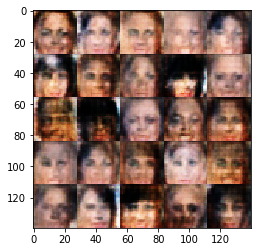

Epoch 2/5... Discriminator Loss: 1.4077... Generator Loss: 0.7765...
Epoch 2/5... Discriminator Loss: 1.4594... Generator Loss: 0.7246...
Epoch 2/5... Discriminator Loss: 1.3958... Generator Loss: 0.7626...
Epoch 2/5... Discriminator Loss: 1.3745... Generator Loss: 0.7226...
Epoch 2/5... Discriminator Loss: 1.4229... Generator Loss: 0.7975...
Epoch 2/5... Discriminator Loss: 1.3720... Generator Loss: 0.8178...
Epoch 2/5... Discriminator Loss: 1.4343... Generator Loss: 0.7850...
Epoch 2/5... Discriminator Loss: 1.4245... Generator Loss: 0.7367...
Epoch 2/5... Discriminator Loss: 1.4009... Generator Loss: 0.8573...
Epoch 2/5... Discriminator Loss: 1.4287... Generator Loss: 0.8248...


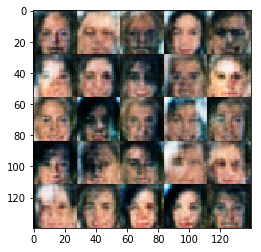

Epoch 2/5... Discriminator Loss: 1.4406... Generator Loss: 0.7769...
Epoch 2/5... Discriminator Loss: 1.4084... Generator Loss: 0.9049...
Epoch 2/5... Discriminator Loss: 1.3881... Generator Loss: 0.8318...
Epoch 2/5... Discriminator Loss: 1.3993... Generator Loss: 0.8019...
Epoch 2/5... Discriminator Loss: 1.4498... Generator Loss: 0.8298...
Epoch 2/5... Discriminator Loss: 1.4269... Generator Loss: 0.8498...
Epoch 2/5... Discriminator Loss: 1.3681... Generator Loss: 0.7848...
Epoch 2/5... Discriminator Loss: 1.4186... Generator Loss: 0.7933...
Epoch 2/5... Discriminator Loss: 1.4114... Generator Loss: 0.8632...
Epoch 2/5... Discriminator Loss: 1.3765... Generator Loss: 0.8699...


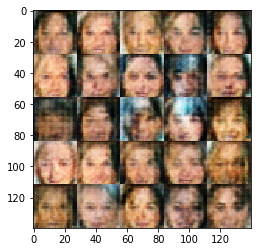

KeyboardInterrupt: 

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4
smooth = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1,smooth, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。